# New dataset vs our dataset

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_directory = '/data0/practical-sose23/brain-age/data/hbn/HBN_RAW/'

eid_list = []
for item in os.listdir(data_directory):
    item_path = os.path.join(data_directory, item)
    if os.path.isdir(item_path):
        eid_list.append(item)
        
print(len(eid_list))

3027


In [3]:
metadata_directory0 = '/data0/practical-sose23/brain-age/data/hbn-metadata/'
metadata_directory1 = '/data0/practical-sose23/brain-age/data/bap/'

In [4]:
# List all CSV files in the directory
csv_files = [file_name for file_name in os.listdir(data_directory) if file_name.endswith('.csv')]

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate over each CSV file
for file_name in tqdm(csv_files):
    file_path = os.path.join(data_directory, file_name)
    # Read the 'Sex' and 'Age' columns from the current CSV file
    data = pd.read_csv(file_path)
    # Append the data to the combined DataFrame
    combined_data = pd.concat([combined_data, data], ignore_index=True)

# Filter the DataFrame
combined_data = combined_data[combined_data['EID'].isin(eid_list)]
# Delete rows with repeated EID values
combined_data = combined_data[~combined_data['EID'].duplicated()]

print(len(combined_data), len(combined_data['EID'].unique()))
    
# Save the combined data to a new CSV file
combined_data.to_csv(metadata_directory0 + 'hbn-metadata.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 555.97it/s]

3027 3027


3027


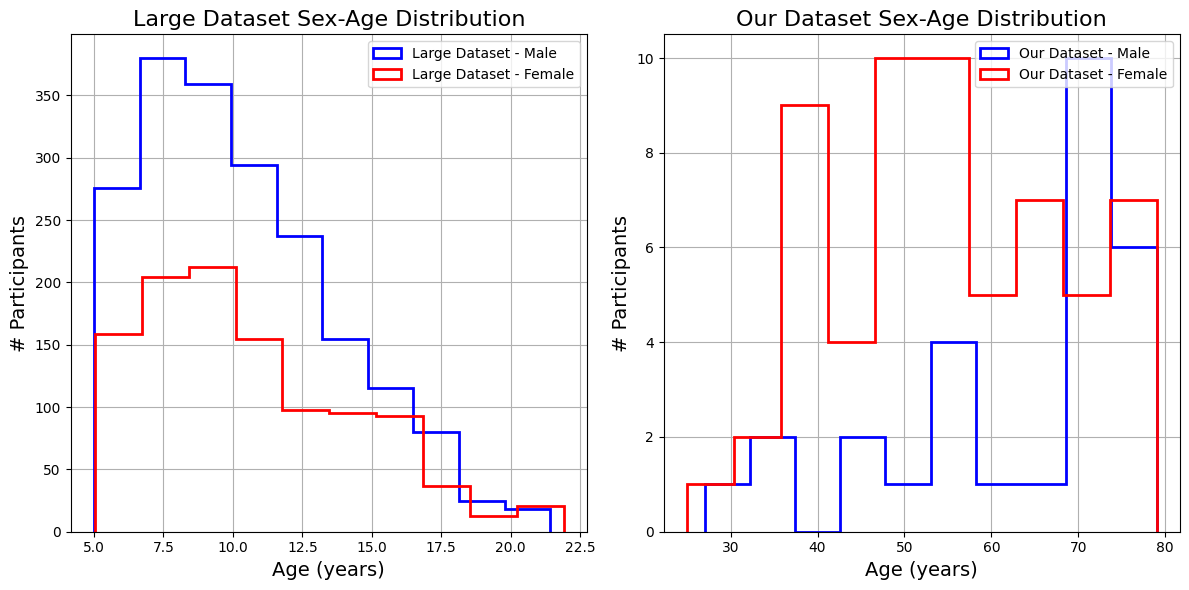

In [8]:
# Read the combined data from the CSV file
file_name0 = 'hbn-metadata.csv'
df0 = pd.read_csv(metadata_directory0 + file_name0, usecols=['Sex', 'Age'])

# Read data from Excel sheets
file_name1 = 'clinical_data_updated_2020-08-04.ods'
df1_1 = pd.read_excel(metadata_directory1 + file_name1, sheet_name='chronic_pain_patients', skiprows=1)
df1_2 = pd.read_excel(metadata_directory1 + file_name1, sheet_name='healthy_controls')

# Concatenate the two dataframes
df1 = pd.concat([df1_1, df1_2], ignore_index=True)

# Map the sex values to meaningful labels ('Males' and 'Females')
df0['Sex'] = df0['Sex'].map({0: 'Male', 1: 'Female'})
df1['Sex (m/f)'] = df1['Sex (m/f)'].map({'m': 'Male', 'f': 'Female'})

# Rename column names
new_column_names = {'Age (years)': 'Age', 'Sex (m/f)': 'Sex'}
df1 = df1.rename(columns=new_column_names)

# Select columns of interest
df1 = df1[['Age', 'Sex']]

print(len(df0))

# Plot the sex-age distribution
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms for large dataset (df0)
ax0.hist(df0[df0['Sex'] == 'Male']['Age'], histtype="step", color='b', linewidth=2, label='Large Dataset - Male')
ax0.hist(df0[df0['Sex'] == 'Female']['Age'], histtype="step", color='r', linewidth=2, label='Large Dataset - Female')
ax0.set_xlabel('Age (years)', fontsize=14)
ax0.set_ylabel('# Participants', fontsize=14)
ax0.set_title('Large Dataset Sex-Age Distribution', fontsize=16)
ax0.legend(loc='upper right')
ax0.grid(True)

# Plot histograms for our dataset (df1)
ax1.hist(df1[df1['Sex'] == 'Male']['Age'], histtype="step", color='b', linewidth=2, label='Our Dataset - Male')
ax1.hist(df1[df1['Sex'] == 'Female']['Age'], histtype="step", color='r', linewidth=2, label='Our Dataset - Female')
ax1.set_xlabel('Age (years)', fontsize=14)
ax1.set_ylabel('# Participants', fontsize=14)
ax1.set_title('Our Dataset Sex-Age Distribution', fontsize=16)
ax1.legend(loc='upper right')
ax1.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Count the number of males and females
sex_counts = df0['Sex'].value_counts()

# Calculate the percentage distribution
sex_distribution = sex_counts / sex_counts.sum() * 100

print(sex_distribution)

Male      64.077991
Female    35.922009
Name: Sex, dtype: float64


# Preprocessing

In [2]:
import os
import mne
import matplotlib.pyplot as plt

In [ ]:
file_path = '/data0/practical-sose23/brain-age/data/bap/raw/chronic_pain_patients/various/preprocessed/Exp_eyes_closed_vp15_eyes_closed.vhdr'

sfreq = 135
filters = {"lpf":45, "hpf":0.5, "nf":50}

# Load EEG data into an EEG raw object
eeg_obj = mne.io.read_raw_brainvision(file_path, verbose=False, preload=True)
eeg_obj = eeg_obj.drop_channels(['LE', 'RE'])

# Set channel types for all channels to 'eeg'
eeg_obj.set_channel_types({channel: 'eeg' for channel in eeg_obj.ch_names})

# Correct channel types of LE and RE
# eeg_obj.set_channel_types({'LE':'misc', 'RE':'misc'})

In [11]:
# Applying a notch filter
# eeg_obj = eeg_obj.notch_filter(freqs=filters['nf'], notch_widths=0.5, method='spectrum_fit')
eeg_obj = eeg_obj.filter(l_freq=filters['hpf'], h_freq=filters['lpf'], fir_design='firwin')
eeg_obj = eeg_obj.resample(sfreq=sfreq)
eeg_obj.compute_psd(fmax=80).plot(show='line')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 6601 samples (6.601 sec)



ValueError: Requested fmax (80 Hz) must not exceed ½ the sampling frequency of the data (67.5 Hz).

In [ ]:
# Duration in seconds
duration = 1

eeg_obj0 = eeg_obj.copy().crop(tmax=duration)
eeg_obj_avg_ch = eeg_obj.copy().set_eeg_reference(ref_channels="average")
eeg_obj1 = eeg_obj_avg_ch.copy().crop(tmax=duration)

data0, times0 = eeg_obj0[:1]
data1, times1 = eeg_obj1[:1]

plt.figure(figsize=(10, 6))
plt.plot(times0, data0.T, color='blue', label='Curve 1')
plt.plot(times1, data1.T, color='red', label='Curve 2')

plt.xlabel('Time (s)')
plt.ylabel('EEG Signal')
plt.title('EEG Signal Plot')

plt.show()

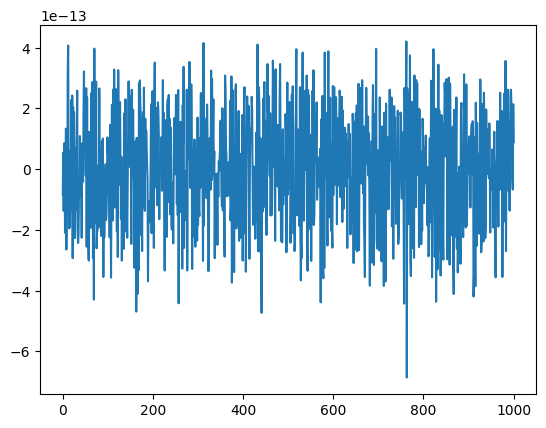

In [5]:
average_channel = eeg_obj.copy().crop(tmax=1).get_data().mean(axis=0)
# median_channel = np.median(eeg_obj.get_data(), axis=0)
# print(eeg_obj.get_data().min()-eeg_obj.get_data().max())
plt.plot(average_channel)
plt.show()

(63, 4050)


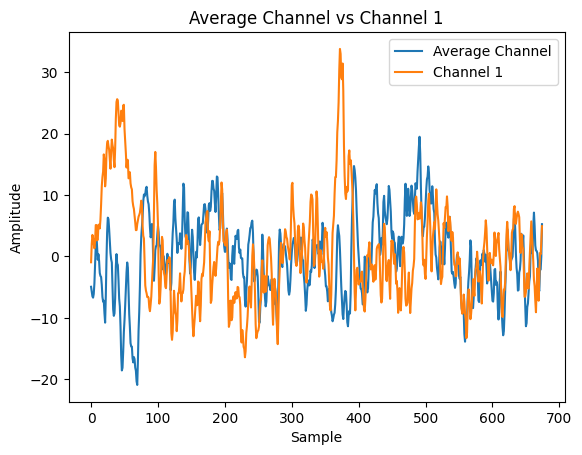

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# file_path = '/data0/practical-sose23/brain-age/data/bap/preprocessed/healthy_controls/preprocessed/Exp_eyes_closed_vpH68_eyes_closed/Exp_eyes_closed_vpH68_eyes_closed_6.npy'
file_path = '/data0/practical-sose23/brain-age/data/hbn/preprocessed/rest/NDARZZ830JM7/EEG/raw/mat_format/RestingState/RestingState_6.npy'
with open(file_path, 'rb') as in_file:
    eeg_npy = np.load(in_file)

print(eeg_npy.shape)


# Compute the average channel
average_channel = np.mean(eeg_npy, axis=0)

# Plotting 135 samples for the average channel
plt.plot(average_channel[:135 * 5], label='Average Channel')

# Plotting 135 samples for channel number 1
plt.plot(eeg_npy[0][:135 * 5], label='Channel 1')

plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Average Channel vs Channel 1')
plt.legend()
plt.show()

In [7]:
# # The Average Reference
# channel_names = eeg_obj.ch_names
# eeg_obj.set_eeg_reference(ref_channels="average")
# print(len(channel_names), len(eeg_obj.ch_names))
# fig = eeg_obj.plot(duration=10.0, start=0.0, n_channels=1, show_scrollbars=False, show_scalebars=False, scalings='auto', show=False)

# eeg_obj = eeg_obj.pick(picks=channel_names)

# eeg_obj.compute_psd().plot()

In [5]:
# Load the standard 10-20 montage (positions of electrodes)
montage = mne.channels.make_standard_montage('standard_1020')

# Set the montage for the raw object
eeg_obj.set_montage(montage)

<RawBrainVision | Exp_eyes_closed_vp15_eyes_closed.dat, 65 x 300002 (300.0 s), ~148.9 MB, data loaded>

Removed notch frequencies (Hz):
     50.00 : 3717 windows
Setting 2289 of 300002 (0.76%) samples to NaN, retaining 297713 (99.24%) samples.
Effective window size : 0.256 (s)


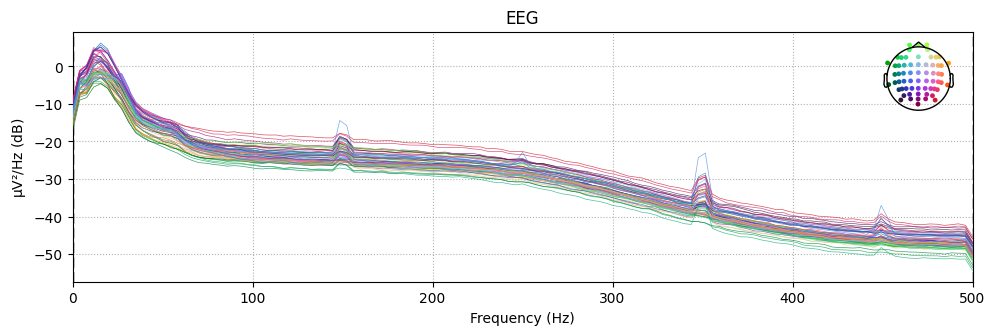

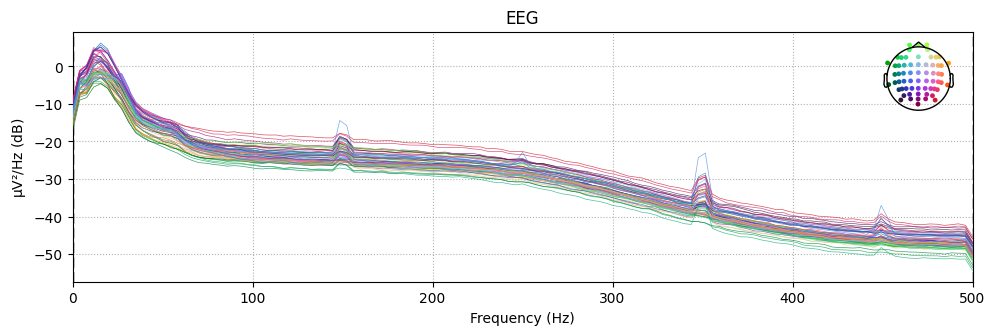

In [4]:
# Applying a notch filter
eeg_obj = eeg_obj.notch_filter(freqs=filters['nf'], notch_widths=0.5, method='spectrum_fit')

eeg_obj.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Setting 2289 of 300002 (0.76%) samples to NaN, retaining 297713 (99.24%) samples.
Effective window size : 0.256 (s)


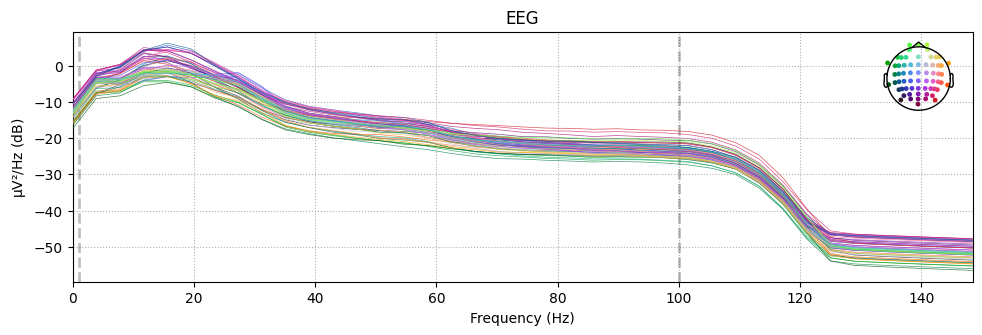

In [5]:
eeg_obj = eeg_obj.filter(l_freq=filters['hpf'], h_freq=filters['lpf'], fir_design='firwin')
eeg_obj.compute_psd(fmax=150).plot(show='line')

Setting 687 of 90001 (0.76%) samples to NaN, retaining 89314 (99.24%) samples.
Effective window size : 0.853 (s)


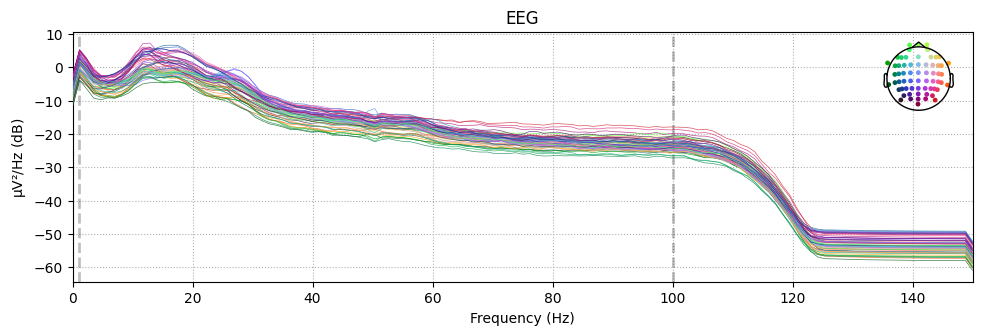

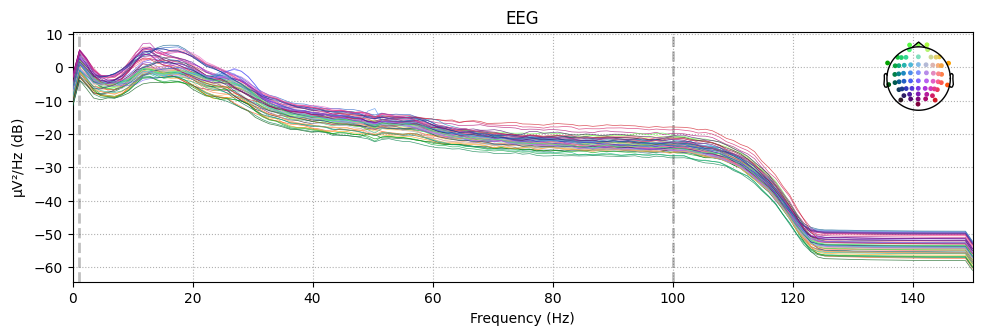

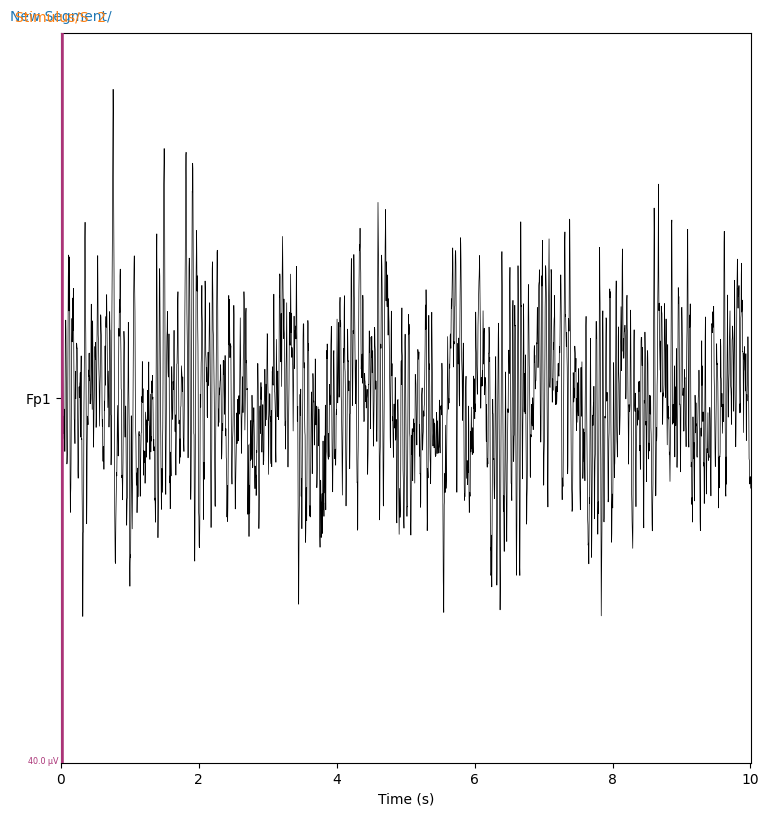

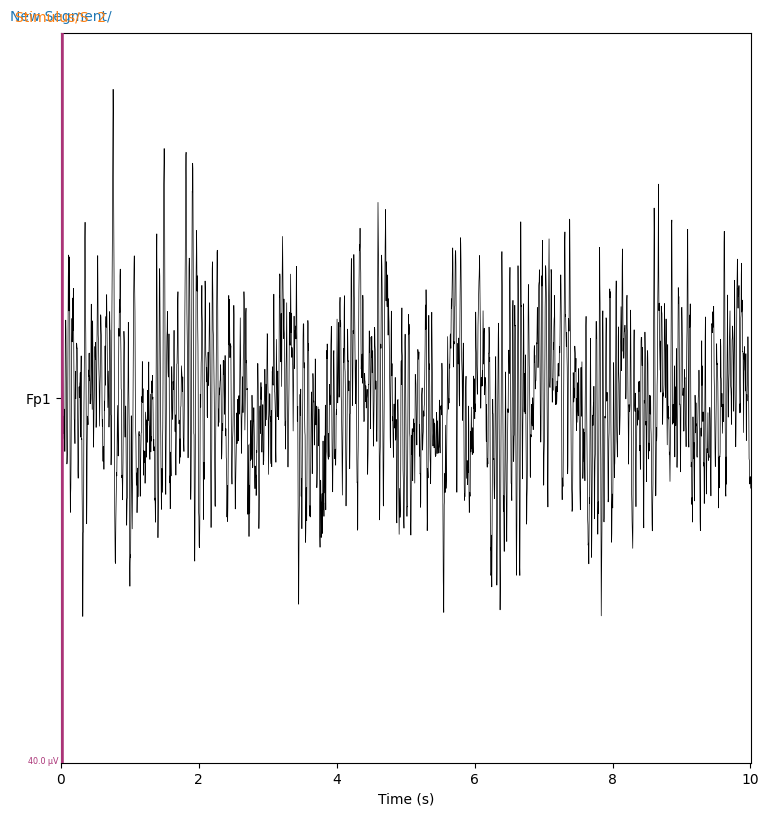

In [8]:
eeg_obj = eeg_obj.resample(sfreq=sfreq)
eeg_obj.compute_psd(fmax=150).plot()
eeg_obj.plot(n_channels=1, show_scrollbars=False)